In [7]:
import hyper_param as hp

In [8]:
prices = hp.get_price_history().squeeze()

In [9]:
start_t = 1000
max_t = len(prices) - 2 # -2 so that can see the next price from the last t
t = start_t

In [10]:
BUY = -1
SELL = 1
HOLD = 0

In [11]:
#t = 2000 - num_coins: 0 - money: 48.6 - next_action: None. Which is much higher than all other policies

In [12]:
# create the training dataset
# X = [price1, price2, price3, ..., price 10] (m x 10) where m = number of training examples
# Y = (m, ) array of 1: increase, 0: stays the same, -1: decrease

X = []
y = []

t = start_t
m = max_t - start_t
for i in range(m): #(max_t - start_t):
    past_ten_prices = prices[t-9: t+1]
    current_price = prices[t]
    next_price = prices[t + 1]
    label = 0
    if next_price > current_price:
        label = 1
    elif next_price < current_price:
        label = -1
    # print 'past_10: {} - next: {} - label: {}'.format(past_ten_prices, next_price, label)
    t += 1
    X.append(past_ten_prices)
    y.append(label)
    
print X
print y
    

[array([ 9.61,  9.2 ,  9.09,  9.27,  9.2 ,  8.97,  8.96,  7.98,  8.07,  8.03]), array([ 9.2 ,  9.09,  9.27,  9.2 ,  8.97,  8.96,  7.98,  8.07,  8.03,  7.32]), array([ 9.09,  9.27,  9.2 ,  8.97,  8.96,  7.98,  8.07,  8.03,  7.32,  7.3 ]), array([ 9.27,  9.2 ,  8.97,  8.96,  7.98,  8.07,  8.03,  7.32,  7.3 ,  7.1 ]), array([ 9.2 ,  8.97,  8.96,  7.98,  8.07,  8.03,  7.32,  7.3 ,  7.1 ,  7.58]), array([ 8.97,  8.96,  7.98,  8.07,  8.03,  7.32,  7.3 ,  7.1 ,  7.58,  7.77]), array([ 8.96,  7.98,  8.07,  8.03,  7.32,  7.3 ,  7.1 ,  7.58,  7.77,  7.78]), array([ 7.98,  8.07,  8.03,  7.32,  7.3 ,  7.1 ,  7.58,  7.77,  7.78,  7.8 ]), array([ 8.07,  8.03,  7.32,  7.3 ,  7.1 ,  7.58,  7.77,  7.78,  7.8 ,  7.86]), array([ 8.03,  7.32,  7.3 ,  7.1 ,  7.58,  7.77,  7.78,  7.8 ,  7.86,  8.61]), array([ 7.32,  7.3 ,  7.1 ,  7.58,  7.77,  7.78,  7.8 ,  7.86,  8.61,  8.9 ]), array([ 7.3 ,  7.1 ,  7.58,  7.77,  7.78,  7.8 ,  7.86,  8.61,  8.9 ,  8.62]), array([ 7.1 ,  7.58,  7.77,  7.78,  7.8 ,  7.86,  8

In [13]:
# split train test
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [14]:
# now build a neural net that given a price will give whether price will increase or decrease compared to current price?
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(100, 500), random_state=1)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_train)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train, y_predict)
print 'Training accuracy: {}'.format(accuracy)

Training accuracy: 0.495457721873


In [15]:
# now build a neural net that given a price will give whether price will increase or decrease compared to current price?
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 500), random_state=1)
clf.fit(X_train, y_train)
y_test_predict = clf.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_test_predict)
print 'Test accuracy: {}'.format(accuracy)

Test accuracy: 0.45


In [17]:
# train on:
# t = start_t
# m = max_t - start_t
# Training accuracy: 0.526536312849
# solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 500), random_state=1
# Test accuracy: 0.4875

In [1]:
import pickle
# save the model to disk
filename = 'naive_neuralnet.sav'
# pickle.dump(clf, open(filename, 'wb'))
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print 'Test accuracy: {}'.format(result)

NameError: name 'X_test' is not defined

In [20]:
# Use the trained neural net to trade

s = (start_t, 0, 0, None) # (t, num_coins_hold, money_so_far, next_action); 
# next_action = None: then take action based on dynamics of price, else take the specified next action
# action: -1: buy, 1: sell, 0: hold (probably not used for now)
for i in range(1000): #(max_t - start_t):
    t, num_coins_hold, money_so_far, next_action = s
    current_price = prices[t]
    ten_prices = prices[t-9: t+1]
#     next_price = prices[t + 1]
    if next_action:
        if next_action == BUY: # buy
            num_coins_hold += 1
            money_so_far -= current_price
            next_action = None
        if next_action == SELL: # sell
            num_coins_hold -= 1
            money_so_far += current_price
            next_action = None
    else:
        # take action based on dynamics of price
        if loaded_model.predict([ten_prices])[0] == 1: # price will increase, then buy to hedge, sell in next time step
            #print loaded_model.predict([ten_prices])[0]
            # buy now to hedge
            num_coins_hold += 1
            money_so_far -= current_price
            # sell in next time step
            next_action = SELL
        elif loaded_model.predict([ten_prices])[0] == -1: # price will decrease, then sell to gain, buy in next time step
            #print loaded_model.predict([ten_prices])[0]
            # sell to gain
            num_coins_hold -= 1
            money_so_far += current_price           
            # buy back in next time step
            next_action = BUY
        else:
            # don't do anything, take action based on price dynamics at next time step
            next_action = None
    
    s = (t + 1, num_coins_hold, money_so_far, next_action)
    #print 't = {} - num_coins: {} - money: {} - next_action: {}'.format(t + 1, num_coins_hold, money_so_far, next_action)
   
print 't = {} - num_coins: {} - money: {} - next_action: {}'.format(t + 1, num_coins_hold, money_so_far, next_action)

t = 2000 - num_coins: 0 - money: 8.44 - next_action: None


In [21]:
#t = 2000 - num_coins: 0 - money: 8.44 - next_action: None (range 1000)

In [22]:
# also why the neural net keeps outputing negative values?

In [5]:
# TODO: change to run 100-timestep epsisodes
def generate_NN_1_step_policy_ideal(start_time, prices, policy_length=100):
    policy = []
    s = (start_time, 0, 0, None) # (t, num_coins_hold, money_so_far, next_action); 
    # next_action = None: then take action based on dynamics of price, else take the specified next action
    # action: -1: buy, 1: sell, 0: hold (probably not used for now)
    for i in range(policy_length): #(max_t - start_t):
        t, num_coins_hold, money_so_far, next_action = s
        current_price = prices[t]
        ten_prices = prices[t-9: t+1]
        next_price = prices[t + 1]
        if next_action:
            if next_action == BUY: # buy
                policy.append(BUY)
                num_coins_hold += 1
                money_so_far -= current_price
                next_action = None
            if next_action == SELL: # sell
                policy.append(SELL)
                num_coins_hold -= 1
                money_so_far += current_price
                next_action = None
        else:
            # take action based on dynamics of price
            if next_price > current_price: # price will increase, then buy to hedge, sell in next time step
                policy.append(BUY)
                #print loaded_model.predict([ten_prices])[0]
                # buy now to hedge
                num_coins_hold += 1
                money_so_far -= current_price
                # sell in next time step
                next_action = SELL
            elif next_price > current_price: # price will decrease, then sell to gain, buy in next time step
                policy.append(SELL)
                #print loaded_model.predict([ten_prices])[0]
                # sell to gain
                num_coins_hold -= 1
                money_so_far += current_price           
                # buy back in next time step
                next_action = BUY
            else:
                # don't do anything, take action based on price dynamics at next time step
                next_action = None
                policy.append(HOLD)
        s = (t + 1, num_coins_hold, money_so_far, next_action)
        #print 't = {} - num_coins: {} - money: {} - next_action: {}'.format(t + 1, num_coins_hold, money_so_far, next_action)
    return policy
    print 't = {} - num_coins: {} - money: {} - next_action: {}'.format(t + 1, num_coins_hold, money_so_far, next_action)

In [22]:
# TODO: change to run 100-timestep epsisodes
def generate_NN_1_step_policy(start_time, prices, policy_length=100):
    policy = []
    s = (start_time, 0, 0, None) # (t, num_coins_hold, money_so_far, next_action); 
    # next_action = None: then take action based on dynamics of price, else take the specified next action
    # action: -1: buy, 1: sell, 0: hold (probably not used for now)
    for i in range(policy_length): #(max_t - start_t):
        t, num_coins_hold, money_so_far, next_action = s
        current_price = prices[t]
        ten_prices = prices[t-9: t+1]
    #     next_price = prices[t + 1]
        if next_action:
            if next_action == BUY: # buy
                policy.append(BUY)
                num_coins_hold += 1
                money_so_far -= current_price
                next_action = None
            if next_action == SELL: # sell
                policy.append(SELL)
                num_coins_hold -= 1
                money_so_far += current_price
                next_action = None
        else:
            # take action based on dynamics of price
            # print 'ten_prices: {}'.format(ten_prices)
            if loaded_model.predict([ten_prices])[0] == 1: # price will increase, then buy to hedge, sell in next time step
                policy.append(BUY)
                #print loaded_model.predict([ten_prices])[0]
                # buy now to hedge
                num_coins_hold += 1
                money_so_far -= current_price
                # sell in next time step
                next_action = SELL
            elif loaded_model.predict([ten_prices])[0] == -1: # price will decrease, then sell to gain, buy in next time step
                policy.append(SELL)
                #print loaded_model.predict([ten_prices])[0]
                # sell to gain
                num_coins_hold -= 1
                money_so_far += current_price           
                # buy back in next time step
                next_action = BUY
            else:
                # don't do anything, take action based on price dynamics at next time step
                next_action = None
                policy.append(HOLD)
        s = (t + 1, num_coins_hold, money_so_far, next_action)
        #print 't = {} - num_coins: {} - money: {} - next_action: {}'.format(t + 1, num_coins_hold, money_so_far, next_action)
    return policy, num_coins, money_so_far
    print 't = {} - num_coins: {} - money: {} - next_action: {}'.format(t + 1, num_coins_hold, money_so_far, next_action)

In [33]:
import evaluate_v2 as evaluate

In [3]:
import random
prices = hp.get_price_history().squeeze()

reward_array = []
for i in range(hp.get_evaluation_step()):
    random_time = random.randint(1000, 2000)
    policy = generate_NN_1_step_policy(random_time, prices, 100)
    #print 'Policy: {}'.format(policy)
    reward = evaluate.evaluate_reward(policy, prices, random_time)
    reward_array.append(reward)

evaluate.print_statistics(reward_array)

NameError: name 'hp' is not defined

In [23]:
prices = hp.get_price_history().squeeze()

def upper_bound_of_maximum_gain(time_step, prices, horizon=100):
    #all_prices_in_100_time_step = np.array(prices[time_step: time_step + horizon])
    all_prices_in_100_time_step = np.array(prices[time_step: time_step + horizon])
    closing_price = all_prices_in_100_time_step[-1]
    diff = all_prices_in_100_time_step - closing_price
    return np.sum(np.absolute(diff))
    
def upper_bound_of_maximum_gain_50(time_step, prices, horizon=100):
    #all_prices_in_100_time_step = np.array(prices[time_step: time_step + horizon])
    all_prices_in_100_time_step = np.array(prices[time_step: time_step + horizon])
    closing_price = all_prices_in_100_time_step[-1]
    diff = all_prices_in_100_time_step - closing_price
    diff_50 = diff[:50]
    return np.sum(np.absolute(diff_50))    
    

In [32]:

import random
prices = hp.get_price_history().squeeze()
random.seed(1000)
reward_array = []
for i in range(hp.get_evaluation_step()):
    random_time = random.randint(1000, 2000)
    #print random_time
    policy = generate_NN_1_step_policy(random_time, prices, 100)
    #policy = generate_NN_1_step_policy_ideal(random_time, prices, 100)
    #print 'Policy: {}'.format(policy)
    reward = evaluate.evaluate_reward(policy, prices, random_time)
    upper_bound_of_max_gain = upper_bound_of_maximum_gain(random_time, prices)
    upper_bound_of_max_gain_50 = upper_bound_of_maximum_gain_50(random_time, prices)
#     print 'Reward: {} - Upper bound: {} - Upper bound first 50: {}'.format(reward, upper_bound_of_max_gain, upper_bound_of_max_gain_50)
    reward_array.append(reward)

evaluate.print_statistics(reward_array)

AttributeError: 'module' object has no attribute 'print_statistics_95_confidence'

In [32]:
random.seed(1000)
print list(random.sample(range(1000, 2000), 30))

[1777, 1669, 1099, 1352, 1467, 1534, 1978, 1130, 1671, 1364, 1488, 1203, 1666, 1227, 1458, 1040, 1974, 1487, 1461, 1714, 1415, 1888, 1023, 1833, 1468, 1811, 1945, 1983, 1176, 1698]


In [24]:

import numpy as np
import random
import hyper_param
import qlearning
import pickle
import evaluate_v2

random.seed(1000)

def evaluate_reward(policy, test_data, random_index):
    policy_length = len(policy)
    reward = np.dot(policy, test_data[random_index:random_index+policy_length])
    reward -= (sum(policy)*test_data[random_index+policy_length-1])
    return reward

def upper_bound_of_maximum_gain(time_step, prices, horizon=100):
    #all_prices_in_100_time_step = np.array(prices[time_step: time_step + horizon])
    all_prices_in_100_time_step = np.array(prices[time_step: time_step + horizon])
    closing_price = all_prices_in_100_time_step[-1]
    diff = all_prices_in_100_time_step - closing_price
    return np.sum(np.absolute(diff))  

def plotAll(t_array, upper_bound_array, reward_array):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(t_array, upper_bound_array, 'bx')
    plt.plot(t_array, reward_array, 'go')
    plt.show()
    
def plotAll2(t_array, upper_bound_array, reward_array):
    import pylab
    pylab.plot(t_array, upper_bound_array, 'b^', label='upper bound of utility')
    pylab.plot(t_array, reward_array, 'r^', label='utility of our policy')
    pylab.plot(t_array, -np.array(upper_bound_array), 'g^', label='lower bound of utility')
    pylab.legend(loc='upper left')
    pylab.xlabel('t')
    pylab.ylabel('Utility')
    pylab.show()
    
prices = hp.get_price_history().squeeze()
t_array = []
upper_bound_array = []
reward_array = []

for i in range(hp.get_evaluation_step()):
    random_time = random.randint(1000, 2000)
    policy_length = hyper_param.get_policy_length()
    policy, _, __ = generate_NN_1_step_policy(random_time, prices, policy_length)
    #qlearning_policy = qlearning.generate_Q_learning_policy(random_time, policy_length)
    print "Policy: {}".format(policy)
    t_array.append(random_time)
    upper_bound_array.append(upper_bound_of_maximum_gain(random_time, prices))
    reward_array.append(evaluate.evaluate_reward(policy, prices, random_time))
    #reward_array.append(evaluate.evaluate_reward(qlearning_policy, prices, random_time))
    
plotAll2(t_array, upper_bound_array, reward_array)
evaluate_v2.print_statistics(upper_bound_array, reward_array)

NameError: global name 'loaded_model' is not defined

t = 1122 - num_coins: 0 - money: 7.62 - next_action: None
[0, -7.6100000000000003, 0.14999999999999947, -7.4400000000000004, 0.20999999999999996, -7.0700000000000003, 0.46999999999999975, 8.1799999999999997, 0.54999999999999982, 8.0899999999999999, 0.67999999999999972, 7.9399999999999995, 0.74999999999999911, 7.9299999999999988, 0.86999999999999922, -6.080000000000001, 0.87999999999999901, 6.9399999999999986, 1.2899999999999983, -3.7500000000000018, 1.3099999999999978, 6.3599999999999977, 1.3899999999999979, 5.7399999999999975, 2.0299999999999976, -2.6900000000000022, 2.7699999999999978, 8.5699999999999967, 3.3299999999999965, -1.5600000000000032, 3.8399999999999972, -1.360000000000003, 4.1899999999999968, 9.5799999999999965, 4.2899999999999965, 9.6499999999999968, 4.4399999999999968, 9.2999999999999972, 4.5899999999999972, -0.23000000000000309, 4.639999999999997, 9.8099999999999969, 4.8399999999999972, -0.15000000000000302, 5.0099999999999971, 10.099999999999998, 5.0399999999999983, -

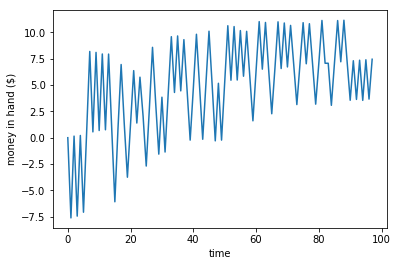

In [30]:
# ideal policy of 1 step:
# assuming perfect knowledge of next price (if the neural net will output 100 accuracy of wheter price increase or decrease)
# if price will increase, then buy to hedge, sell in next time step.
# if price will decrease, then sell to gain, buy in next time step.
# else take action based on dynamics of price.


#s = (start_t, 0, 0, None) # (t, num_coins_hold, money_so_far, next_action); 
s = (1023, 0, 0, None)
# next_action = None: then take action based on dynamics of price, else take the specified next action
# action: -1: buy, 1: sell, 0: hold (probably not used for now)
money = []
for i in range(99): #(max_t - start_t):
    t, num_coins_hold, money_so_far, next_action = s
    money.append(money_so_far)
    current_price = prices[t]
    next_price = prices[t + 1]
    if next_action:
        if next_action == BUY: # buy
            num_coins_hold += 1
            money_so_far -= current_price
            next_action = None
        if next_action == SELL: # sell
            num_coins_hold -= 1
            money_so_far += current_price
            next_action = None
    else:
        # take action based on dynamics of price
        if next_price > current_price: # price will increase, then buy to hedge, sell in next time step
            # buy now to hedge
            num_coins_hold += 1
            money_so_far -= current_price
            # sell in next time step
            next_action = SELL
        elif next_price < current_price: # price will decrease, then sell to gain, buy in next time step
            # sell to gain
            num_coins_hold -= 1
            money_so_far += current_price           
            # buy back in next time step
            next_action = BUY
        else:
            # don't do anything, take action based on price dynamics at next time step
            next_action = None
            
    s = (t + 1, num_coins_hold, money_so_far, next_action)
print 't = {} - num_coins: {} - money: {} - next_action: {}'.format(t + 1, num_coins_hold, money_so_far, next_action)

print money
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(len(money) - 1), money[:-1])
plt.xlabel('time')
plt.ylabel('money in hand ($)')
plt.show()